# Consensus boundaries clustering

In [33]:
import pandas as pd
import src
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE

from pybedtools.bedtool import BedTool
from pybedtools import cleanup

figure_path = src.figures_path / "boundary_clustering"
os.makedirs(figure_path, exist_ok=True)

In [12]:
window = 25000

consensus_boundaries = pd.read_csv(src.interim_data_path / "consensus_boundaries" / 'consensus_boundaries_w{}.tsv'.format(window), sep="\t")
cell_types = sorted(set(consensus_boundaries.cell_type.str.split(",").sum()))
consensus_boundaries.head()

,chr,start,end,boundary_uid,cell_type,n_cell_types,n_boundaries,Ery,MK,Mac0,Mon,nB,nCD4,nCD8,length,covered_genome
0,chr1,1612500,1612500,Mon_0000_start,Mon,1,1,0,0,0,1,0,0,0,1,3.223947e-10
1,chr1,1646875,1646875,nB_0000_start,nB,1,1,0,0,0,0,1,0,0,1,3.223947e-10
2,chr1,1842500,1847500,"nB_0000_end,Ery_0000_start,Mon_0000_end","Ery,nB,Mon",3,3,1,0,0,1,1,0,0,5001,1.612296e-06
3,chr1,2112500,2112500,"nB_0001_start,Mac0_0000_start","nB,Mac0",2,2,0,0,1,0,1,0,0,1,3.223947e-10
4,chr1,2342500,2350000,"nB_0001_end,Mac0_0000_end,Ery_0000_end,nB_0002...","nCD8,Ery,nB,Mac0",4,5,1,0,1,0,2,0,1,7501,2.418282e-06


## Clsutering by cell types composition

In [14]:
fontsize=25

/home/nanni/anaconda3/envs/hic_reconcile_ctcf/lib/python3.7/site-packages/seaborn/matrix.py:701: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/home/nanni/anaconda3/envs/hic_reconcile_ctcf/lib/python3.7/site-packages/seaborn/matrix.py:701: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/home/nanni/anaconda3/envs/hic_reconcile_ctcf/lib/python3.7/site-packages/seaborn/matrix.py:318: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  ax.figure.draw(ax.figure.canvas.get_renderer())


<Figure size 432x288 with 0 Axes>

/home/nanni/anaconda3/envs/hic_reconcile_ctcf/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


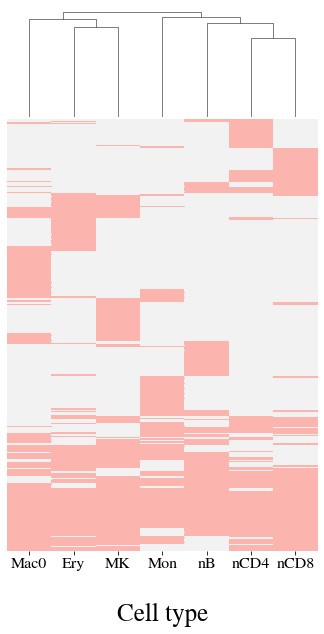

In [15]:
fig = plt.figure()
ax = sns.clustermap(data=consensus_boundaries[cell_types] > 0, 
                    yticklabels=False, figsize=(7, 10), cmap='Pastel1_r')
ax.ax_row_dendrogram.set_visible(False)
ax.cax.set_visible(False)
ax.ax_heatmap.set_xlabel("\nCell type", fontsize=fontsize)
fig.savefig(figure_path / "conserved_bounadries_clustering.pdf", bbox_inches='tight', transparent=True)
plt.show()

### TSNE

In [17]:
def __get_category(x):
    cats =[]
    if x.lymphoid > 0:
        cats.append("lymphoid")
    if x.myeloid > 0:
        cats.append("myeloid")
    if x.blood > 0: 
        cats.append("blood")
    if len(cats) == 0:
        return "None"
    return "-".join(cats)

consensus_boundaries['cell_type_category'] = pd.DataFrame({
    'lymphoid': consensus_boundaries['nCD4'] + consensus_boundaries['nCD8'] + consensus_boundaries['nB'],
    'myeloid': consensus_boundaries['Mon'] + consensus_boundaries['Mac0'],
    'blood': consensus_boundaries['Ery'] + consensus_boundaries['MK']
}).apply(__get_category, axis=1)

In [19]:
tsne = TSNE(n_components=2)
tsne_comps = tsne.fit_transform(consensus_boundaries[cell_types])

#### By lineage

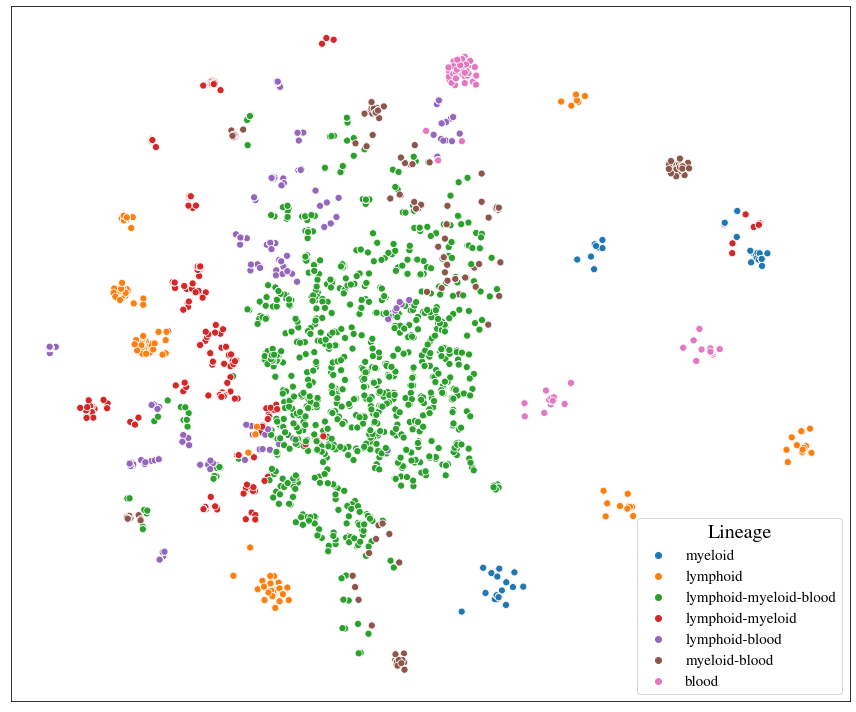

In [21]:
fig = plt.figure(figsize=(12,10))
ax = sns.scatterplot(x=tsne_comps[:, 0], y=tsne_comps[:, 1], hue=consensus_boundaries.cell_type_category.tolist(), s=50)
ax.set_xticks([])
ax.set_yticks([])
plt.legend(title='Lineage', title_fontsize=20, fontsize='15')
fig.savefig(figure_path / "conserved_bounadries_TSNE_lineage.pdf", bbox_inches='tight', transparent=True)
plt.show()

#### By conservation

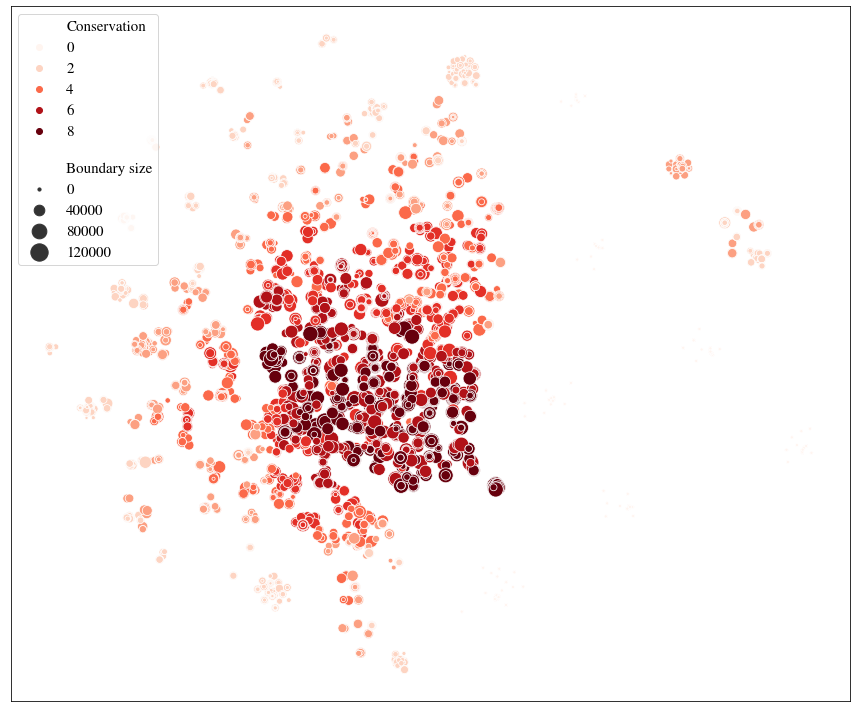

In [93]:
fig = plt.figure(figsize=(12,10))
ax = sns.scatterplot(x=tsne_comps[:, 0], y=tsne_comps[:, 1], size=consensus_boundaries.length.rename("\nBoundary size"), 
                     sizes=(10,300), hue=consensus_boundaries.n_cell_types.rename("Conservation"), palette='Reds')
ax.set_xticks([])
ax.set_yticks([])
plt.legend(fontsize='15')
fig.savefig(figure_path / "conserved_bounadries_TSNE_conservation_with_size.pdf", bbox_inches='tight', transparent=True)
plt.show()

#### By lineage and size

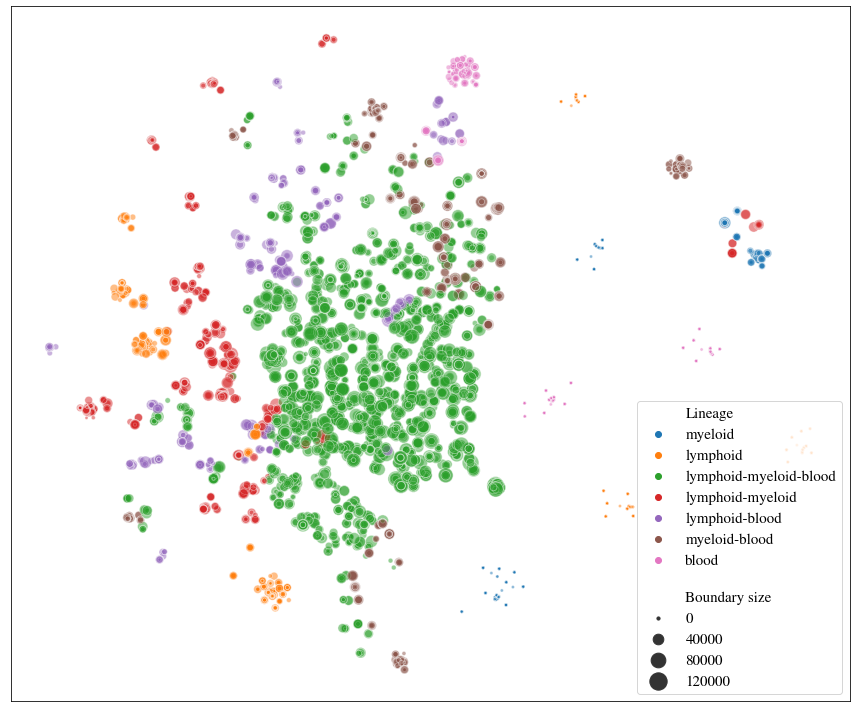

In [78]:
fig = plt.figure(figsize=(12,10))
ax = sns.scatterplot(x=tsne_comps[:, 0], y=tsne_comps[:, 1], size=consensus_boundaries.length.rename("\nBoundary size"), sizes=(10,300), hue=consensus_boundaries.cell_type_category.rename("Lineage"), alpha=0.5)
ax.set_xticks([])
ax.set_yticks([])
plt.legend(fontsize='15', loc='lower right')
fig.savefig(figure_path / "conserved_bounadries_TSNE_lineage_with_size.pdf", bbox_inches='tight', transparent=True)
plt.show()

#### By number of CTCFs

In [31]:
ctcfs = pd.read_csv(src.interim_data_path / "ctcf_scores.tsv", sep="\t")
ctcfs.head()

,chr,start,end,orientation,ctcf_id,MotifScore,ChipSeqScore,rank_score_aggregate
0,chr1,237593,237953,>,0,9.790746,12.637052,1.392043e+09
1,chr1,521337,521697,>,1,10.259412,13.835230,1.563464e+09
2,chr1,714087,714447,>,2,9.893988,9.332479,1.241503e+09
3,chr1,805232,805362,>,3,14.365820,46.633221,3.272974e+09
4,chr1,839966,840326,>,4,16.393501,60.461779,3.574601e+09


In [94]:
n_ctcfs = BedTool.from_dataframe(consensus_boundaries.assign(end=lambda x: x.end + 1))\
                 .map(BedTool.from_dataframe(ctcfs), c=5, o='count')\
                 .to_dataframe(names=consensus_boundaries.columns.tolist()+['n_ctcfs']).n_ctcfs

/home/nanni/anaconda3/envs/hic_reconcile_ctcf/lib/python3.7/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)


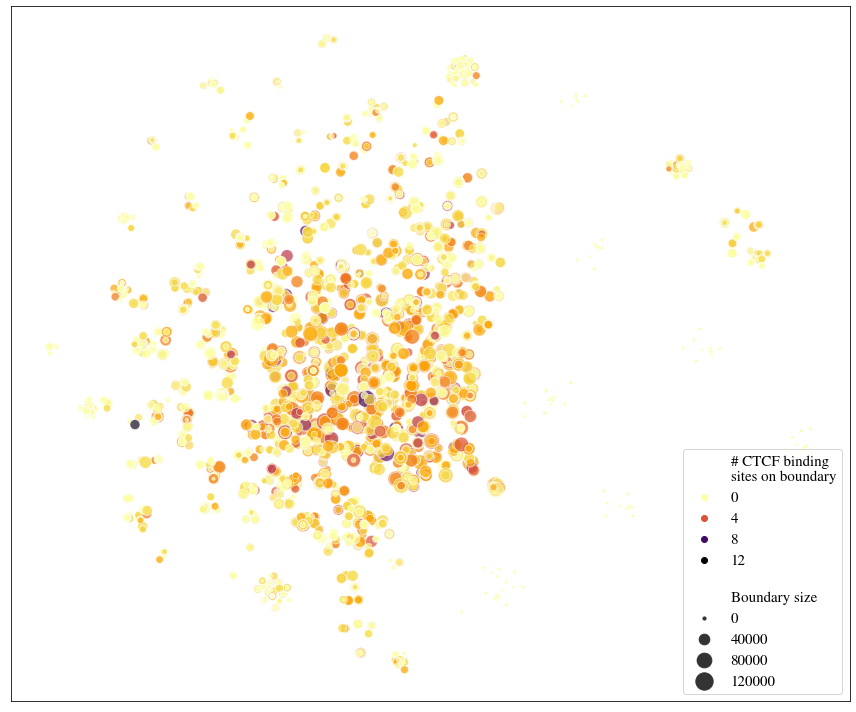

In [89]:
fig = plt.figure(figsize=(12,10))
ax = sns.scatterplot(x=tsne_comps[:, 0], y=tsne_comps[:, 1], size=consensus_boundaries.length.rename("\nBoundary size"), 
                     sizes=(10,300), hue=n_ctcfs.rename("# CTCF binding\nsites on boundary"), alpha=0.7, palette='inferno_r')
ax.set_xticks([])
ax.set_yticks([])
plt.legend(fontsize='15', loc='lower right')
fig.savefig(figure_path / "conserved_bounadries_TSNE_n_ctcfs_with_size.pdf", bbox_inches='tight', transparent=True)
plt.show()